## Phase transition in the transverse-field Ising model and Jordan-Wigner transform

### Preliminary improts

In [262]:
import numpy as np
from numpy import pi as PI
from numpy import ndarray, sqrt, sin, cos, exp, log2, log, real, imag
from itertools import count
from scipy.linalg import expm, sqrtm
import matplotlib.pyplot as plt

from qutils import (
    put_paulis_on_pos,
    put_matr_on_pos,
    densmatr_check,
    PSI_PLUS,
    PSI_MINUS,
    SIGMA,
    SPIN_CR,
    SPIN_AN,
    vnentropy,
    fidelity,
    get_mutinfo_matrix,
    rho_thermal,
    anticom
)

### Transverse-field Ising model

Consider a uniform 1D transverse-field Ising model on a ring
$$
    H = -J \sum_{i=0}^{n-1} S^x_iS^x_{(i+1)~{\rm mod}~n} - h \sum_{i=0}^{n-1} S^i_z,
$$
where $n$ is the number of spins, $J$ and $h$ are some constants, and the following notations are used:
$$
    S^\alpha_i = \frac{1}{2}\sigma^\alpha_i,\quad \alpha=x,z;
$$
$$
    \sigma^x_i = |\uparrow\rangle_i\langle\downarrow|+|\downarrow\rangle_i\langle\uparrow|,\quad
    \sigma^z_i = |\uparrow\rangle_i\langle\uparrow|-|\downarrow\rangle_i\langle\downarrow|;
$$
$$
    |\uparrow\rangle = \begin{pmatrix}1\\0 \end{pmatrix},\quad |\downarrow\rangle = \begin{pmatrix}0\\1\end{pmatrix}.
$$
(here subindices denote labels of affected particles).
Note that $H=0$ and $J>0(<0)$ corresponds to ferro-(antiferro)magnetic.

We also introduce spin raising and lowering operators
$$
    \sigma^+_i=|\uparrow\rangle_i \langle \downarrow|=\begin{pmatrix} 0 & 1\\0 & 0\end{pmatrix},\quad
    \sigma^-_i=|\downarrow\rangle_i \langle \uparrow|=\begin{pmatrix} 0 & 0\\1 & 0\end{pmatrix}.
$$

Let's define spin Hamiltonians with open and periodic boundary conditions.

In [263]:
def get_hmlt_open_true(n: int = 3, J: float = 1.0, h: float = 0.0):
    """The transverse-field Hamiltonina with open boundary conditions"""
    hmlt_open_true = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(n - 1):
        hmlt_open_true -= (
            J * put_paulis_on_pos([1, 1], [i, (i + 1) % n], n) / 4
        )  # mind division by 4 and minus
    for i in range(n):
        hmlt_open_true -= (
            h * put_paulis_on_pos([3], [i], n) / 2
        )  # mind division by 2 and minus
    return hmlt_open_true


def get_hmlt_ring_true(n: int = 3, J: float = 1.0, h: float = 0.0):
    """The transverse-field Hamiltonina with periodic boundary conditions"""
    hmlt_ring_true = get_hmlt_open_true(n=n, J=J, h=h)
    hmlt_ring_true -= J / 4 * put_paulis_on_pos([1, 1], [n-1, 0], n)
    return hmlt_ring_true

Next, let's introduce functions that will make us ferromagentic and antiferromagnetic states.

In [ ]:
def kron_power_state(psi: ndarray, n: int):
    """Makes Kronecker power 'n' of 'psi' in the form psi x psi x ..."""
    assert n > 0
    psi_cur = 1
    for _ in range(n):
        psi_cur = np.kron(psi_cur, psi)
    return psi_cur


def kron_alt_state(psi_arr: ndarray, n: int):
    """Makes an alterneting Kronecker product of 'n' states taken from 'psi_arr' in the form
    psi_arr[0] x psi_arr[1] x psi_arr[0] x psi_arr[1] x ..."""
    m = len(psi_arr)
    psi_cur = 1
    for i in range(n):
        psi_cur = np.kron(psi_cur, psi_arr[i % m])
    return psi_cur


def make_ferr_state(n: int):
    """Makes ferromagnetic state of n spins"""
    psi_right = kron_power_state(PSI_PLUS, n)
    psi_left = kron_power_state(PSI_MINUS, n)
    rho_ferr = 1 / 2 * np.einsum(
        "i,j->ij", psi_right, psi_right.conj()
    ) + 1 / 2 * np.einsum("i,j->ij", psi_left, psi_left.conj())
    return rho_ferr


def make_aferr_state(n: int):
    """Makes anti-ferromagnetic state of n spins"""
    psi_alt1 = kron_alt_state([PSI_PLUS, PSI_MINUS], n)
    psi_alt2 = kron_alt_state([PSI_MINUS, PSI_PLUS], n)
    rho_aferr = 1 / 2 * np.einsum(
        "i,j->ij", psi_alt1, psi_alt1.conj()
    ) + 1 / 2 * np.einsum("i,j->ij", psi_alt2, psi_alt2.conj())
    return rho_aferr

Lets' play a bit with open and periodic boundaries

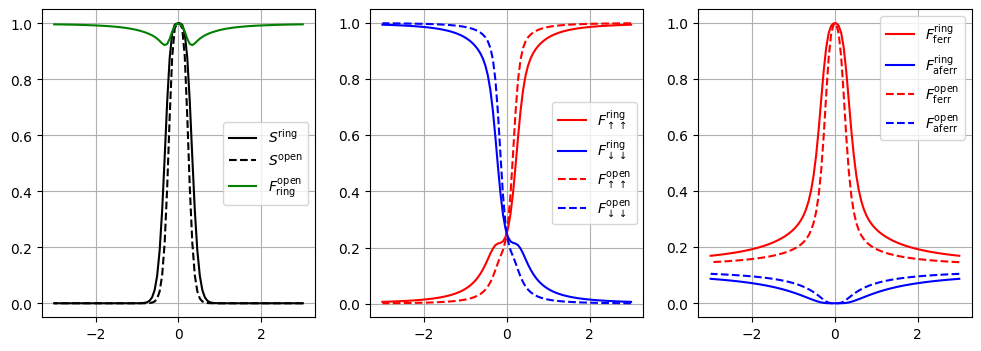

In [265]:
# === Parameters ===
n = 2
J = 1
beta = 20
# ------------------
h_min = -3
h_max = -3
points_num = 100
# ==================

psi_up = kron_power_state(np.array([1, 0]), n)
psi_down = kron_power_state(np.array([0, 1]), n)
rho_ferr = make_ferr_state(n)
rho_aferr = make_aferr_state(n)

h_arr = np.linspace(-h_min, h_max, points_num)
data_dict = {
    "ring-up": [],
    "ring-down": [],
    "ring-ferr": [],
    "ring-aferr": [],
    "ring-entr": [],
    "open-up": [],
    "open-down": [],
    "open-ferr": [],
    "open-aferr": [],
    "open-entr": [],
    "entr-ring": [],
    "entr-open": [],
    "ring-open": []
}

for h in h_arr:
    hmlt_ring = get_hmlt_ring_true(n=n, h=h, J=J)
    hmlt_open = get_hmlt_open_true(n=n, h=h, J=J)

    rho_ring = rho_thermal(hmlt_ring, beta)
    rho_open = rho_thermal(hmlt_open, beta)

    data_dict["ring-up"].append(fidelity(rho_ring, psi_up))
    data_dict["ring-down"].append(fidelity(rho_ring, psi_down))
    data_dict["open-up"].append(fidelity(rho_open, psi_up))
    data_dict["open-down"].append(fidelity(rho_open, psi_down))

    data_dict["ring-ferr"].append(fidelity(rho_ring, rho_ferr))
    data_dict["ring-aferr"].append(fidelity(rho_ring, rho_aferr))
    data_dict["open-ferr"].append(fidelity(rho_open, rho_ferr))
    data_dict["open-aferr"].append(fidelity(rho_open, rho_aferr))

    data_dict["entr-ring"].append(vnentropy(rho_ring))
    data_dict["entr-open"].append(vnentropy(rho_open))
    data_dict["ring-open"].append(fidelity(rho_ring, rho_open))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax2.plot(h_arr, data_dict["ring-up"], "r-", label=r"$F_{\uparrow\uparrow}^{\rm ring}$")
ax2.plot(
    h_arr, data_dict["ring-down"], "b-", label=r"$F_{\downarrow\downarrow}^{\rm ring}$"
)
ax2.plot(h_arr, data_dict["open-up"], "r--", label=r"$F_{\uparrow\uparrow}^{\rm open}$")
ax2.plot(
    h_arr, data_dict["open-down"], "b--", label=r"$F_{\downarrow\downarrow}^{\rm open}$"
)

ax1.plot(h_arr, data_dict["entr-ring"], "k-", label=r"$S^{\rm ring}$")
ax1.plot(h_arr, data_dict["entr-open"], "k--", label=r"$S^{\rm open}$")
ax1.plot(h_arr, data_dict["ring-open"], "g-", label=r"$F^{\rm open}_{\rm ring}$")

ax3.plot(
    h_arr,
    data_dict["ring-ferr"],
    "r-",
    label=r"$F_{\rm ferr}^{\rm ring}$",
)
ax3.plot(
    h_arr,
    data_dict["ring-aferr"],
    "b-",
    label=r"$F_{\rm  aferr}^{\rm ring}$",
)
ax3.plot(
    h_arr,
    data_dict["open-ferr"],
    "r--",
    label=r"$F_{\rm ferr}^{\rm open}$",
)
ax3.plot(
    h_arr,
    data_dict["open-aferr"],
    "b--",
    label=r"$F_{\rm aferr}^{\rm open}$",
)


ax1.grid()
ax1.legend()
ax2.grid()
ax2.legend()
ax3.grid()
ax3.legend()

Let's look on correlations.

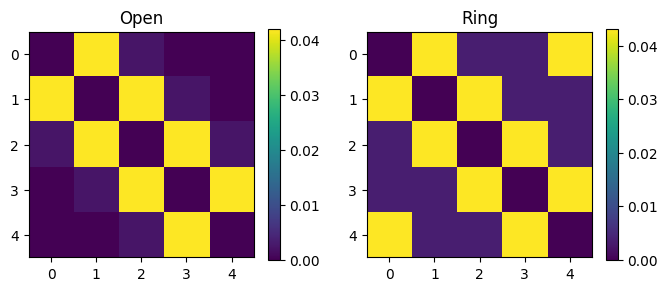

In [266]:
n = 5
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
titles = ["Open", "Ring"]
for i, hmlt in enumerate(
    [
        get_hmlt_open_true(n=n, J=1.0, h=0.5),  # open boundaries
        get_hmlt_ring_true(n=n, J=1.0, h=0.5),  # periodic boundaries
    ]
):  
    rho = rho_thermal(hmlt)
    info_matr = get_mutinfo_matrix(rho, n)
    im = ax[i].imshow(info_matr)
    ax[i].set_title(titles[i])
    plt.colorbar(im, ax=ax[i])

### Jordan-Wigner transformation
Let
$$
    f_i^{\dagger}:=\left(\prod_{j<i} (-\sigma^z_j)\right) \sigma^+_i, \quad 
    f_i:=\left(\prod_{j<i} (-\sigma^z_j)\right) \sigma^-_i.
$$
One can check that $\{f_i^{(\dagger)}\}$ form a set of fermionic annihilation (creation) operators. 
In particular
$$
    \{f_i^\dagger, f_j\}=\delta_{ij},
$$
where $\{\cdot,\cdot\}$ stands for an anticommutator, and $\delta_{ij}$ denotes a standard Kroneker symbol.

Note that for $n=1$ we have the following correspondence
$$
|\uparrow\rangle \leftrightarrow f^\dagger|{\rm vac}\rangle=|1\rangle,\quad |\downarrow\rangle \leftrightarrow |{\rm vac}\rangle.
$$

Let's start with introducing anihilation and creation operators.

In [267]:
def an(i: int, n: int) -> ndarray:
    """Fermi anihillation operator on the i-th site of n-sites chain"""
    assert i < n
    M = 1
    for j in range(i):
        M = np.kron(M, -SIGMA[3])
    M = np.kron(M, SPIN_AN)
    for _ in range(n - i - 1):
        M = np.kron(M, SIGMA[0])
    return M


def cr(i: int, n: int) -> ndarray:
    """Fermi creation operator on the i-th site of n-sites chain"""
    return np.transpose(an(i, n))


def num(i: int, n: int) -> ndarray:
    """Fermi number of particles operator on the i-th site of n-sites chain"""
    return cr(i, n) @ an(i, n)

In [268]:
# Sanity check
n = 5

eye = np.eye(2**n)
for i in range(n):
    for j in range(n):
        # {a_i, a_j} = 0:
        assert np.isclose(np.linalg.norm(anticom(an(i, n), an(j, n))), 0)
        # {a^+_i, a^+_j} = 0:
        assert np.isclose(np.linalg.norm(anticom(cr(i, n), cr(j, n))), 0)
        # {a^+_i, a_i} = delta_ij:
        if i == j:
            assert np.isclose(np.linalg.norm(anticom(cr(i, n), an(j, n)) - eye), 0)
        else:
            assert np.isclose(np.linalg.norm(anticom(cr(i, n), an(j, n))), 0)

Let's play a bit.

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[ 0. -1.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  0.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


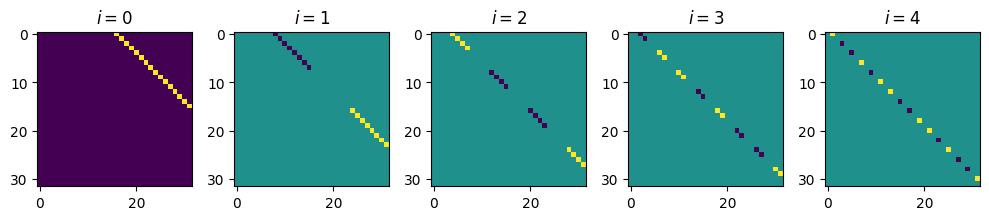

In [269]:
print(np.real(cr(0, 2)))
print(np.real(cr(1, 2)))
print(np.real(anticom(cr(1, 2), an(1, 2))))
n = 5
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
for i in range(n):
    ax[i].imshow(real(cr(i, 5)))
    ax[i].set_title(f"$i={i}$")
fig.tight_layout()

### Jordan-Wigner transformation of the trasnverse-field Izing model

One can check that
$$S_z^i=\frac{1}{2}\sigma_z^i=f_i^\dagger f_i - \frac{1}{2},$$
$$\sigma^x_{i}\sigma^x_{i+1}=(\sigma^+_i+\sigma^-_i)(\sigma^+_{i+1}+\sigma^-_{i+1})=(f^\dagger_i+f_i)e^{{\rm i}\pi f_i^\dagger f_i}(f^\dagger_{i+1}+f_{i+1})=(f^\dagger_i-f_i)(f^\dagger_{i+1}+f_{i+1}), \quad i=0,1,\ldots,{\color{red}n-2}.$$

So the Izing model with the **open** boundaries can be mapped to
$$H_{\rm open}=-\frac{J}{4}\sum_{i=0}^{\color{red}n-2}(f^\dagger_i-f_i)(f^\dagger_{i+1}+f_{i+1}) -h\sum_{i=0}^{n-1} f_i^\dagger f_i.$$

However for the closing term within the **periodic** boudaries we have
$$\sigma^x_{n-1}\sigma^x_{0}=e^{{\rm i}\pi\sum_{j=0}^{n-2}f^\dagger_jf_j}(f^\dagger_{n-1}+f_{n-1})(f^\dagger_0+f_0)=e^{{\rm i}\pi n_{\rm tot}} e^{-{\rm i}\pi n_{n-1}}(f^\dagger_{n-1}+f_{n-1})(f^\dagger_0+f_0)={\color{red}-e^{{\rm i}\pi n_{\rm tot}}}(f^\dagger_{n-1}-f_{n-1})(f^\dagger_0+f_0).$$

So, the true fermionc Hamiltonian takes the form
$$H_{\rm ring}=H_{\rm open}-\frac{J}{4}{\color{red}(-e^{-{\rm i}\pi n_{\rm tot}})}(f^\dagger_{n-1}-f_{n-1})(f^\dagger_0+f_0).$$

At the same time we can consider an **approximated** version that is quadratic in fermionic operations and has good properties with respect to the Fourier transform of fermionic operations:
$$H_{\rm appr}=H_{\rm open}-\frac{J}{4}(f^\dagger_{n-1}-f_{n-1})(f^\dagger_0+f_0)=
-\frac{J}{4}\sum_{i=0}^{\color{red}n-1}(f^\dagger_i-f_i)(f^\dagger_{i+1}+f_{i+1}) -h\sum_{i=0}^{n-1} f_i^\dagger f_i.$$
Let's make some checks.

In [270]:
n = 4

# Making original Hamiltonians
hmlt_open_true = get_hmlt_open_true(n=n, J=J, h=h)
hmlt_ring_true = get_hmlt_ring_true(n=n, J=J, h=h)

# Trying to make the same Hamiltonians but using fermionic operators
# 1. Open boundary condition case
hmlt_open_check = np.zeros((2**n, 2**n), dtype=complex)
for i in range(n - 1):  # interactions
    hmlt_open_check -= (
        J / 4 * (cr(i, n) - an(i, n)) @ (cr((i + 1) % n, n) + an((i + 1) % n, n))
    )
for i in range(n):  # local fields
    hmlt_open_check -= h * cr(i, n) @ an(i, n) - h / 2 * np.eye(2**n)

assert np.isclose(np.linalg.norm(hmlt_open_true - hmlt_open_check), 0)  # check

# 2. Periodic boundary conditions fair
n_tot = np.array(
    np.sum(
        [put_matr_on_pos(np.array([[1, 0], [0, 0]]), i, n) for i in range(n)], axis=0
    )
)  # total number of fermions
exp_n_tot = np.diag(np.exp(np.diag(1j * np.pi * n_tot)))
hmlt_ring_check = np.copy(hmlt_open_check)
closing_term_check = (
    -J / 4 * (-exp_n_tot) @ (cr(n - 1, n) - an(n - 1, n)) @ (cr(0, n) + an(0, n))
)  # fair closing term
hmlt_ring_check = hmlt_ring_check + closing_term_check

assert np.isclose(np.linalg.norm(hmlt_ring_true - hmlt_ring_check), 0)  # check

In [271]:
# Approximate Fermionic Hamiltonian for periodic boundary conditions
def get_hmlt_ring_appr(n:int = 3, J: float =1.0, h: float =0.0):
    """Approximate fermionic Hamiltonian for periodic boundary conditions"""
    hmlt_ring_appr = get_hmlt_open_true(n=n, J=J, h=h) - J / 4 * (cr(n-1, n) - an(n-1, n)) @ (cr(0, n) + an(0, n))
    return hmlt_ring_appr

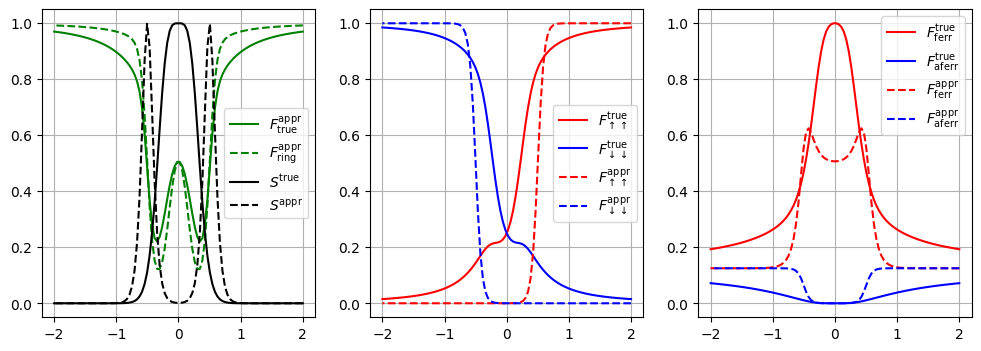

In [272]:
# === Parameters ===
n = 2
J = 1
beta = 20
# ------------------
h_min = -2
h_max = -2
points_num = 100
# ==================

h_arr = np.linspace(-h_min, h_max, points_num)

psi_up = kron_power_state(np.array([1,0]), n)
psi_down = kron_power_state(np.array([0,1]), n)
rho_ferr = make_ferr_state(n)
rho_aferr = make_aferr_state(n)


data_dict = {
    'true_up': [],
    'true_down': [],
    'true_ferr': [],
    'true_aferr': [],
    'appr_up': [],
    'appr_down': [],
    'appr_ferr': [],
    'appr_aferr': [],
    'true_entr': [],
    'appr_entr': [],
    'appr_true': [],
    'appr_open': []
}

for h in h_arr:
    hmlt_ring_true = get_hmlt_ring_true(n=n, h=h, J=J)
    hmlt_open_true = get_hmlt_open_true(n=n, h=h, J=J)
    hmlt_ring_appr = get_hmlt_ring_appr(n=n, h=h, J=J)

    rho_open = rho_thermal(hmlt_open_true, beta)
    rho_true = rho_thermal(hmlt_ring_true, beta)
    rho_appr = rho_thermal(hmlt_ring_appr, beta)

    data_dict['true_up'].append(fidelity(rho_true, psi_up))
    data_dict['true_down'].append(fidelity(rho_true, psi_down))
    data_dict['true_ferr'].append(fidelity(rho_true, rho_ferr))
    data_dict['true_aferr'].append(fidelity(rho_true, rho_aferr))

    data_dict['appr_up'].append(fidelity(rho_appr, psi_up))
    data_dict['appr_down'].append(fidelity(rho_appr, psi_down))
    data_dict['appr_ferr'].append(fidelity(rho_appr, rho_ferr))
    data_dict['appr_aferr'].append(fidelity(rho_appr, rho_aferr))

    data_dict['true_entr'].append(vnentropy(rho_true))
    data_dict['appr_entr'].append(vnentropy(rho_appr))
    data_dict['appr_true'].append(fidelity(rho_appr, rho_true))
    data_dict['appr_open'].append(fidelity(rho_appr, rho_open))
    
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.plot(h_arr, data_dict['appr_true'], 'g-', label=r'$F^{\rm appr}_{\rm true}$')
ax1.plot(h_arr, data_dict['appr_open'], 'g--', label=r'$F^{\rm appr}_{\rm ring}$')
ax1.plot(h_arr, data_dict['true_entr'], 'k-', label=r'$S^{\rm true}$')
ax1.plot(h_arr, data_dict['appr_entr'], 'k--', label=r'$S^{\rm appr}$')

ax2.plot(h_arr, data_dict['true_up'], 'r-', label=r'$F_{\uparrow\uparrow}^{\rm true}$')
ax2.plot(h_arr, data_dict['true_down'], 'b-', label=r'$F_{\downarrow\downarrow}^{\rm true}$')
ax2.plot(h_arr, data_dict['appr_up'], 'r--', label=r'$F_{\uparrow\uparrow}^{\rm appr}$')
ax2.plot(h_arr, data_dict['appr_down'], 'b--', label=r'$F_{\downarrow\downarrow}^{\rm appr}$')

ax3.plot(h_arr, data_dict['true_ferr'], 'r-', label=r'$F_{\rm ferr}^{\rm true}$')
ax3.plot(h_arr, data_dict['true_aferr'], 'b-', label=r'$F_{\rm aferr}^{\rm true}$')
ax3.plot(h_arr, data_dict['appr_ferr'], 'r--', label=r'$F_{\rm ferr}^{\rm appr}$')
ax3.plot(h_arr, data_dict['appr_aferr'], 'b--', label=r'$F_{\rm aferr}^{\rm appr}$')

ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()


After a sequence of transformation one can "diagonalize" $H_{\rm appr}$ to the form
$$H_{\rm apppr}=\sum_{k\in {\rm BZ}} E_k d_k^\dagger d_k,\quad E_k=\frac{1}{2}\sqrt{J^2/4 + Jh\cos(k a) + h^2}$$

Let's look on spectrums...

In [273]:
def get_spectrum(n: int, J: float, h: float) -> tuple[ndarray, ndarray]:
    k_arr = np.arange(-n // 2 + 1, n // 2 + 1) if n % 2 == 0 else np.arange(-(n-1) // 2, (n-1) // 2 + 1)
    k_arr = 2 * PI / n * k_arr
    E_k_arr = sqrt(J ** 2 / 4 + J * h * cos(k_arr) + h ** 2) / 2
    return k_arr, E_k_arr

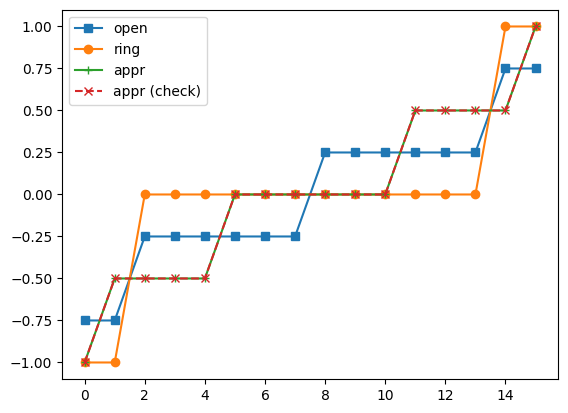

In [274]:
# === Parameters ===
n = 4
J = 1
h = 0
# ==================
hmlt_open_true = get_hmlt_open_true(n, J, h)
hmlt_ring_true = get_hmlt_ring_true(n, J, h)
hmlt_appr_true = get_hmlt_ring_appr(n, J, h)

# Making diagonalized Hamiltonian
_, E_k_arr = get_spectrum(n, J, h)
hmlt_appr_check = np.zeros((2**n, 2**n), dtype=complex)
for i in range(n):
    hmlt_appr_check += put_matr_on_pos(SIGMA[3] * E_k_arr[i], i, n)


plt.plot(np.linalg.eigh(hmlt_open_true)[0], 's-', label='open')
plt.plot(np.linalg.eigh(hmlt_ring_true)[0], 'o-', label='ring')
plt.plot(np.linalg.eigh(hmlt_appr_true)[0], '+-', label='appr')
plt.plot(np.linalg.eigh(hmlt_appr_check)[0], 'x--', label='appr (check)')
plt.legend()

Let's look on correlations...

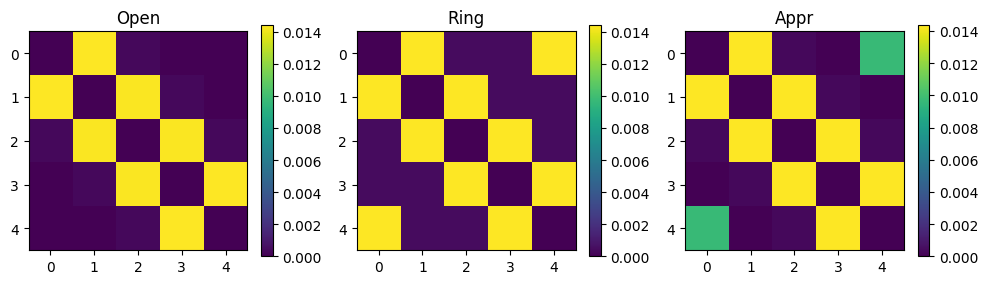

In [275]:
# === Parameters ===
n = 4
J = 1
h = 3.5
# ==================
n = 5
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
titles = ["Open", "Ring", "Appr"]

for i, hmlt in enumerate(
    [
        get_hmlt_open_true(n=n, J=J, h=h),  # open boundaries
        get_hmlt_ring_true(n=n, J=J, h=h),  # periodic boundaries
        get_hmlt_ring_appr(n=n, J=J, h=h),  # approximation
    ]
):  
    rho = rho_thermal(hmlt)
    info_matr = get_mutinfo_matrix(rho, n)
    im = ax[i].imshow(info_matr)
    ax[i].set_title(titles[i])
    plt.colorbar(im, ax=ax[i])

### TBD

In [276]:
def qft(N):
    return np.fft.fft(np.eye(N)) / np.sqrt(N)

def iqft(N):
    return np.fft.ifft(np.eye(N)) * np.sqrt(N)

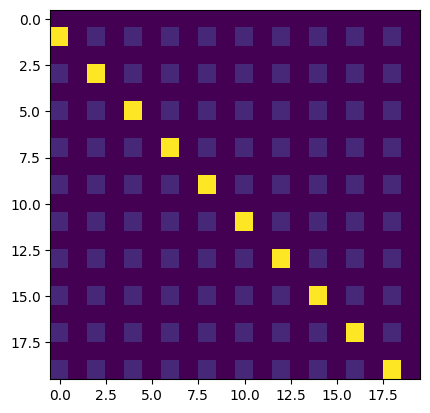

In [277]:
n = 10
M = np.zeros((n * 2, n * 2), dtype=complex)
for i in range(n-1):
    M[(2 * i + 1) % (2 * n), (2 * i + 2) % (2 * n)] = -2 * 1j
plt.imshow(-np.imag(M))

U = qft(n)
U.shape
V = np.zeros((2 * n, 2 * n), dtype=complex)
V[::2, ::2] = U
V[1::2, 1::2] = U
plt.imshow(np.abs(V))

S = V @ M @ V.conj().transpose()
plt.imshow(np.abs(S))